## Градиентный бустинг

### Предварительная обработка данных

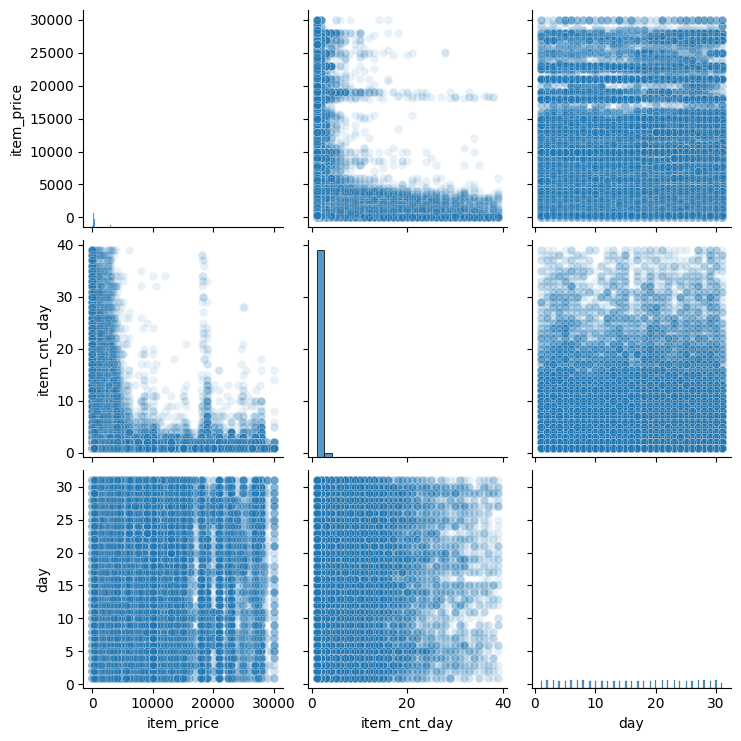

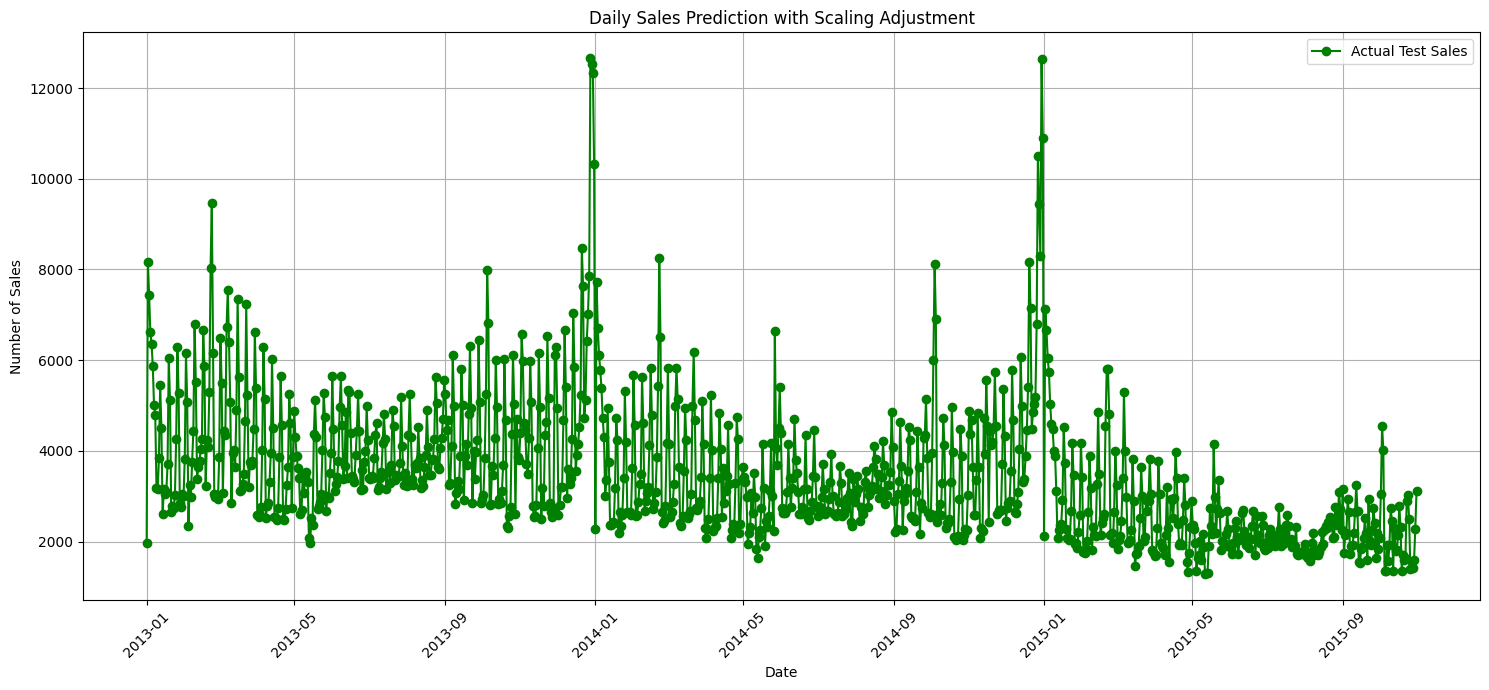

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
sales_train = pd.read_csv('sales_train.csv')

# Очистка данных
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_price'] > 0) & (sales_train['item_price'] < 30000) & (sales_train['item_cnt_day'] < 40)]

# Преобразование даты
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
#sales_train['year'] = sales_train['date'].dt.year
#sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day

# Визуализация с помощью scatterplot matrix
sns.pairplot(sales_train[['item_price', 'item_cnt_day', 'day']], plot_kws={'alpha': 0.1})
plt.show()

test_df = pd.DataFrame({
    'date': sales_train['date'],
    'actual_sales': sales_train['item_cnt_day']
})

daily_test = test_df.groupby('date').agg({
    'actual_sales': 'sum'
}).reset_index()

plt.figure(figsize=(15, 7))
plt.plot(daily_test['date'], daily_test['actual_sales'], label='Actual Test Sales', color='green', marker='o')
plt.title('Daily Sales Prediction with Scaling Adjustment')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Загрузка данных
#sales_train = pd.read_csv('sales_train.csv')

# Идентификация и удаление строк с очевидными выбросами
#sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < sales_train['item_cnt_day'].quantile(0.99))]
#sales_train = sales_train[sales_train['item_price'] > sales_train['item_price'].quantile(0.01)]  # Исключаем распродажи по очень низкой цене

# Преобразование даты
#sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# Расчет двухнедельных и месячных периодов для каждого года
sales_train['year'] = sales_train['date'].dt.year
sales_train['two_week_period'] = sales_train['date'].dt.isocalendar().week // 2 + 1
sales_train['month'] = sales_train['date'].dt.month
sales_train['date_block_week'] = sales_train['year'].astype(str) + '_' + sales_train['two_week_period'].astype(str)
sales_train['date_block_month'] = sales_train['year'].astype(str) + '_' + sales_train['month'].astype(str)

# Расчет средних значений за двухнедельные и месячные периоды
mean_prices_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_price'].mean().reset_index()
mean_sales_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_cnt_day'].mean().reset_index()
mean_prices_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_price'].mean().reset_index()
mean_sales_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_cnt_day'].mean().reset_index()

# Присоединяем средние цены и количество продаж обратно к основным данным
sales_train = sales_train.merge(mean_prices_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_sales_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_prices_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))
sales_train = sales_train.merge(mean_sales_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))

# Фильтрация данных
sales_train['price_diff'] = abs(sales_train['item_price'] - sales_train['item_price_mean_week']) / sales_train['item_price_mean_week']
filtered_data = sales_train[sales_train['price_diff'] > 0.05]

### Обучим модель

In [18]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Загрузка данных
train_data = filtered_data
data_items = pd.read_csv('items.csv')
train_data = pd.merge(train_data, data_items, on=['item_id'])
train_data = train_data.drop(columns=['item_name', 'date_block_week','date_block_month', 'price_diff', 'date_block_num', 'two_week_period'])#, 'year', 'month', 'item_price_mean_week', 'item_price_mean_month'])

# Преобразование столбца даты
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['is_weekend'] = train_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Сортировка по дате
train_data.sort_values(by='date', inplace=True)

# Разделение данных на обучающий и тестовый наборы
cutoff_index = int(len(train_data) * 0.9)
train, test = train_data.iloc[:cutoff_index], train_data.iloc[cutoff_index:]

# Подготовка данных
X_train = train.drop(['item_cnt_day', 'date'], axis=1)
y_train = train['item_cnt_day']
X_test = test.drop(['item_cnt_day', 'date'], axis=1)
y_test = test['item_cnt_day']

# Нормализация числовых признаков (item_price)
scaler = StandardScaler()
X_train['item_price'] = scaler.fit_transform(X_train[['item_price']])
X_test['item_price'] = scaler.transform(X_test[['item_price']])
X_train['item_cnt_day_mean_week'] = scaler.fit_transform(X_train[['item_cnt_day_mean_week']])
X_test['item_cnt_day_mean_week'] = scaler.transform(X_test[['item_cnt_day_mean_week']])
X_train['item_cnt_day_mean_month'] = scaler.fit_transform(X_train[['item_cnt_day_mean_month']])
X_test['item_cnt_day_mean_month'] = scaler.transform(X_test[['item_cnt_day_mean_month']])

X_train['item_price_mean_week'] = scaler.fit_transform(X_train[['item_price_mean_week']])
X_test['item_price_mean_week'] = scaler.transform(X_test[['item_price_mean_week']])
X_train['item_price_mean_month'] = scaler.fit_transform(X_train[['item_price_mean_month']])
X_test['item_price_mean_month'] = scaler.transform(X_test[['item_price_mean_month']])

# Обучение модели
cat_features = ['shop_id', 'item_id', 'item_category_id']
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=3, loss_function='RMSE', verbose=200, task_type="GPU")
model.fit(X_train, y_train, cat_features=cat_features)

# Оценка модели
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

0:	learn: 0.9126515	total: 8.77ms	remaining: 8.76s
200:	learn: 0.7673786	total: 2.07s	remaining: 8.21s
400:	learn: 0.7565981	total: 4.25s	remaining: 6.35s
600:	learn: 0.7477703	total: 6.3s	remaining: 4.19s
800:	learn: 0.7418003	total: 8.39s	remaining: 2.08s
999:	learn: 0.7364871	total: 10.4s	remaining: 0us
MSE: 1.0517984137550138, MAE: 0.2792212075910102, R^2: 0.3814290144454091


### Оценим результаты

                   Features  Importance
7    item_cnt_day_mean_week   31.830059
9   item_cnt_day_mean_month   19.247192
0                   shop_id   12.220205
2                item_price   10.742631
10         item_category_id    8.324668
8     item_price_mean_month    5.723407
1                   item_id    3.852839
3                       day    2.438536
11              day_of_week    2.279628
6      item_price_mean_week    1.695422
5                     month    1.290017
12               is_weekend    0.187963
4                      year    0.167433


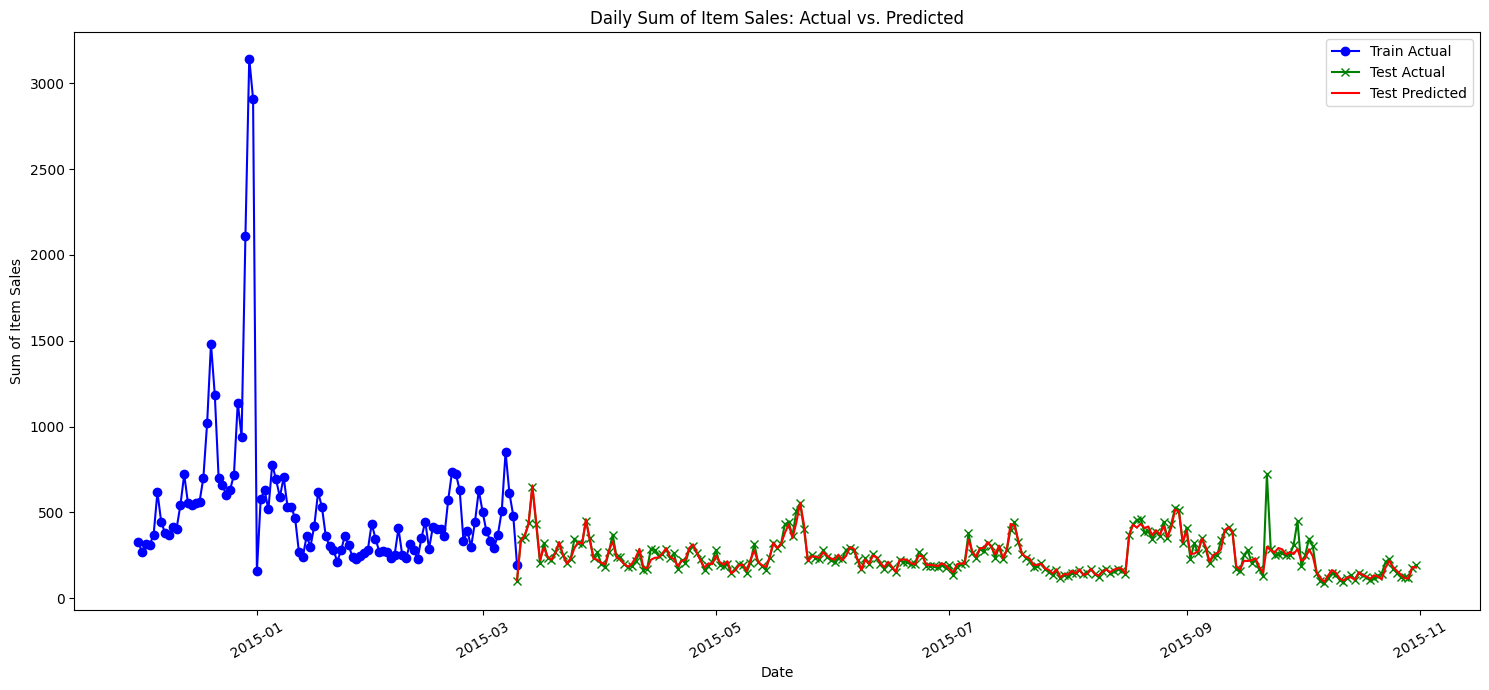

In [19]:
import matplotlib.pyplot as plt

# Вывод важности признаков
feature_importances = model.get_feature_importance()
features = X_train.columns
importance_sales_train = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print(importance_sales_train)


# Группировка данных по дням
train_new= train[train['date'] >= '2014-12-01']
train_grouped = train_new.groupby('date')['item_cnt_day'].sum()
test_grouped = test.groupby('date')['item_cnt_day'].sum()

# Предсказания для тестового набора данных
predictions_series = pd.Series(predictions, index=test.index)

# Группировка предсказаний по дням
predicted_grouped = test.assign(predicted_item_cnt=predictions_series).groupby('date')['predicted_item_cnt'].sum()

# График сравнения группированных данных
plt.figure(figsize=(15, 7))

# Построение графиков
plt.plot(train_grouped.index, train_grouped.values, label='Train Actual', color='blue', marker='o')
plt.plot(test_grouped.index, test_grouped.values, label='Test Actual', color='green', marker='x')
plt.plot(predicted_grouped.index, predicted_grouped.values, label='Test Predicted', color='red', linestyle='-')

plt.title('Daily Sum of Item Sales: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Sum of Item Sales')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
